In [2]:
# install and import umap for dimension reduction
!pip3 install umap-learn
import umap

# common used
import pandas as pd
import numpy as np

# plot result
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import seaborn as sns

# clustering and preprocessing
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering,KMeans,AgglomerativeClustering
from sklearn.preprocessing import StandardScaler,scale, MinMaxScaler

# save/read progress and best result
import pickle
import os

# fix random
import random
random.seed(12345)

     |████████████████████████████████| 69 kB 6.8 MB/s eta 0:00:011
  Created wheel for umap-learn: filename=umap_learn-0.4.6-py3-none-any.whl size=67950 sha256=740f4bc5c5d4b3601350ed08cdb2358c5859d32eaca3282fb011dcc29d2e2d03
  Stored in directory: /home/tianz1/.cache/pip/wheels/9c/18/d0/2bcf7df75d19c6ca6ff8097b12abd4c46879e9a8275e93e651
Successfully built umap-learn


In [4]:
output_text,loop_result = False, False

# load dataset

In [5]:
# load dataset
genedata = pd.read_csv("~/notebooks/datamining/datamininggroupassignment/dataset/genedata.csv")
msdata = pd.read_csv("~/notebooks/datamining/datamininggroupassignment/dataset/msdata.csv")

gene_real   = genedata[["id","class"]]
ms_real = msdata[["id","class"]]

ms_features = msdata.drop(["id","class"],axis = 1)
gene_features = genedata.drop(["id","class"],axis = 1)

# preprocess
# standard scaler
ms_features_scaled = StandardScaler()
ms_features_scaled = ms_features_scaled.fit_transform(ms_features)

# min max
ms_features_minmax     = MinMaxScaler().fit(ms_features).transform(ms_features)
ms_features_log        = np.log(ms_features)
ms_features_log_minmax = MinMaxScaler().fit(np.log(ms_features)).transform(np.log(ms_features))

# MS UMAP AgglomerativeClustering with Best Result and Plot

0.9490004624580719


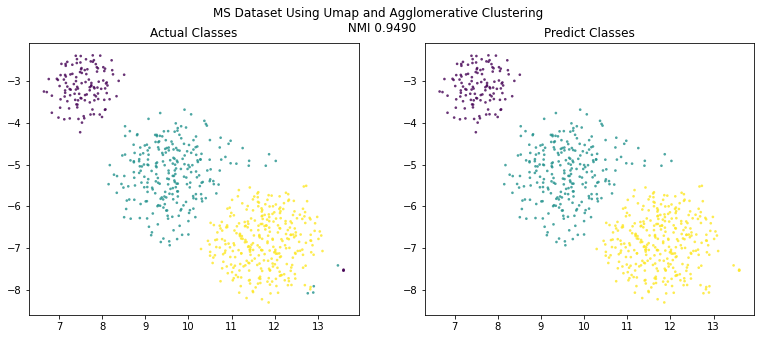

In [4]:
embedding = umap.UMAP(n_neighbors=7,
                      min_dist=0.1,
                      metric="braycurtis",random_state=187).fit_transform(ms_features_log_minmax)
clustering = AgglomerativeClustering(n_clusters=3)
label = clustering.fit_predict(embedding)
NMI = normalized_mutual_info_score(label, ms_real["class"],average_method="geometric")
print(NMI)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))

# replace label so it looks identical in fig
temp1 = np.where(label==2,9,label)
temp2 = np.where(temp1==1,2,temp1)
temp3 = np.where(temp2==0,3,temp2)
label_re = np.where(temp3==9,1,temp3)

ax1.scatter(embedding[:,0], embedding[:,1], 
            c=ms_real["class"], 
            edgecolor='none', 
            alpha=0.8, 
            s=7,cmap='viridis')
ax1.set_title('Actual Classes');

ax2.scatter(embedding[:,0], embedding[:,1], 
            c=label_re, 
            edgecolor='none', 
            alpha=0.8, 
            s=7,cmap='viridis')
ax2.set_title('Predict Classes')
fig.suptitle('MS Dataset Using Umap and Agglomerative Clustering \n NMI 0.9490')
fig.savefig("../submission/ms_scatter_umap_AgglomerativeClustering_0.949.png",dpi=200)

# MS with UMAP Spectral Clustering (Clustering Method 2)

Test MS with umap and Spectral Clustering, with NMI 0.82

canberra 0.8489710505414025


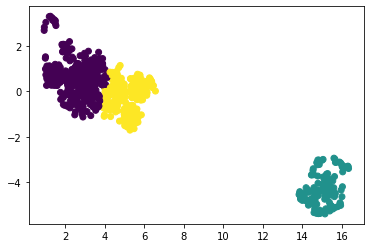

braycurtis 0.8311849259984018


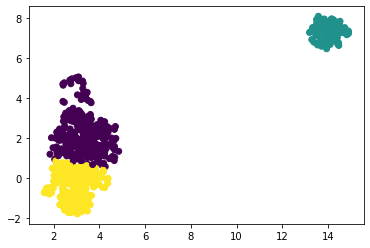

manhattan 0.03827537136657249


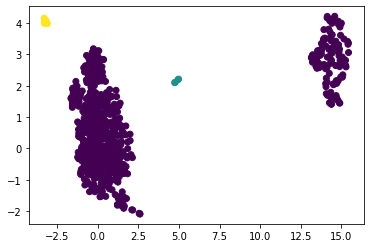

In [5]:
for metric in ["canberra","braycurtis","manhattan"]:
    embedding = umap.UMAP(n_neighbors=3,
                          min_dist=0.1,
                          metric=metric).fit_transform(ms_features)
    clustering = SpectralClustering(n_clusters=3,random_state=0,affinity="rbf")
    label = clustering.fit_predict(embedding)
    print(metric, normalized_mutual_info_score(label, ms_real["class"],average_method="geometric"))
    plt.scatter(x=embedding[:, 0],y=embedding[:, 1],c =label)
    plt.show()

# Gene with best result plot kmeans umap

0.9906346094268289


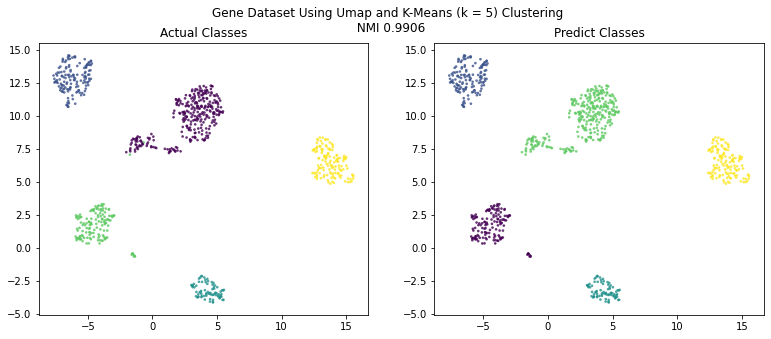

In [6]:
embedding = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric="correlation",random_state=1023).fit_transform(gene_features)
kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=3000, n_init=20, random_state=0)
label = kmeans.fit_predict(embedding)
NMI = normalized_mutual_info_score(label, gene_real["class"],average_method="geometric")
print(NMI)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))

# replace label so it looks identical in fig
temp1 = np.where(label==2,55,label)
temp2 = np.where(temp1==1,44,temp1)
temp3 = np.where(temp2==0,11,temp2)
temp4 = np.where(temp3==3,22,temp3)
label_re = np.where(temp4==4,33,temp4)

ax1.scatter(embedding[:,0], embedding[:,1], 
            c=gene_real["class"], 
            edgecolor='none', 
            alpha=0.8, 
            s=7,cmap='viridis')
ax1.set_title('Actual Classes');

ax2.scatter(embedding[:,0], embedding[:,1], 
            c=label_re, 
            edgecolor='none', 
            alpha=0.8, 
            s=7,cmap='viridis')
ax2.set_title('Predict Classes')
fig.suptitle('Gene Dataset Using Umap and K-Means (k = 5) Clustering \n NMI 0.9906')
fig.savefig("../submission/gene_scatter_umap_kmeans_0.9906.png",dpi=200)

# Gene with plot AgglomerativeClustering umap (Clustering Method 2)

Here we testing the second clustering method of gene dataset, 

[0.16044787 0.113951   0.09510127 0.06306172 0.05096258]
0.4835244350632555
0.8863757087482268


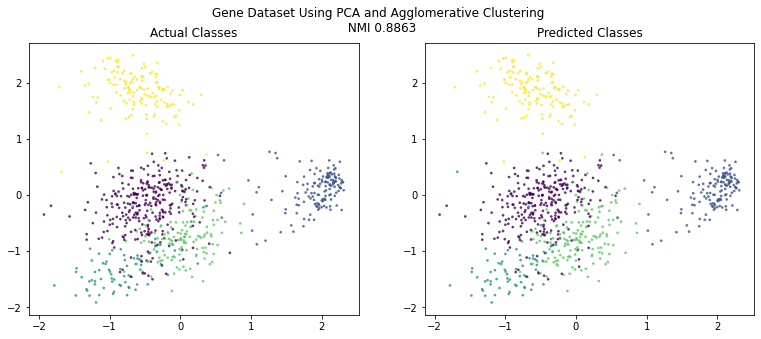

In [6]:
pca = PCA(n_components=5,whiten=True)
pca.fit(gene_features)
gene_features_new = pca.transform(gene_features)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

clustering =  AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
label = clustering.fit_predict(X = gene_features_new)
NMI = normalized_mutual_info_score(label, gene_real["class"],average_method="geometric")
print(NMI)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))

# replace label so it looks identical in fig
temp1 = np.where(label==4,22,label)
temp2 = np.where(temp1==2,4,temp1)
temp3 = np.where(temp2==22,2,temp2)

ax1.scatter(gene_features_new[:, 0], gene_features_new[:, 1], 
            c=gene_real["class"], 
            edgecolor='none', 
            alpha=0.8, 
            s=7,cmap='viridis')
ax1.set_title('Actual Classes');

ax2.scatter(gene_features_new[:, 0], gene_features_new[:, 1], 
            c=temp3, 
            edgecolor='none', 
            alpha=0.8, 
            s=7,cmap='viridis')
ax2.set_title('Predicted Classes')
fig.suptitle('Gene Dataset Using PCA and Agglomerative Clustering \n NMI 0.8863')
fig.savefig("../submission/gene_scatter_pca_kmeans_0.8863.png",dpi=200)

# PCA

## PCA on gene

Use 5 PCA components and in total only explains 48% data. From the plot we can tell the clusters are not entirely sseparate. 

[0.16044787 0.113951   0.09510127 0.06306172 0.05096258]
0.48352443506326304


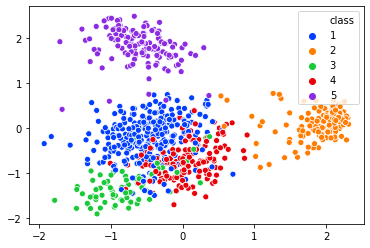

In [8]:
pca = PCA(n_components=5,whiten=True)
pca.fit(gene_features)
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

gene_features_new = pca.transform(gene_features)
color_dict = dict({0:'brown',1:'green',2: 'orange',3: 'red',4: 'dodgerblue',5:"lime",6:"blue"})
sns.scatterplot(gene_features_new[:, 0], gene_features_new[:, 1],marker='o',hue=gene_real["class"],palette=sns.color_palette('bright',gene_real["class"].unique().shape[0]))
plt.show()

## PCA on ms

Use 5 PCA components and in total only explains 5% data. From the plot we can tell the clusters are not entirely sseparate. 

[0.01464844 0.0046384  0.00327283]
0.05766179149081079


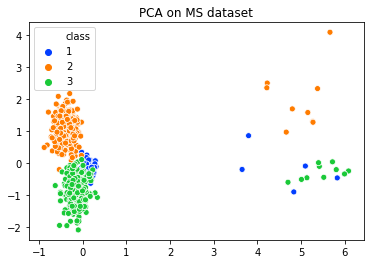

In [9]:
pca = PCA(n_components=15,whiten=True)
pca.fit(ms_features)
print(pca.explained_variance_ratio_[:3])
print(pca.explained_variance_ratio_.sum())
ms_features_new = pca.transform(ms_features)
color_dict = dict({0:'brown',1:'green',2: 'orange',3: 'red',4: 'dodgerblue',5:"lime"})
sns.scatterplot(ms_features_new[:, 0], ms_features_new[:, 1],marker='o',hue=ms_real["class"],palette=sns.color_palette('bright',ms_real["class"].unique().shape[0])).set_title("PCA on MS dataset")
plt.show()

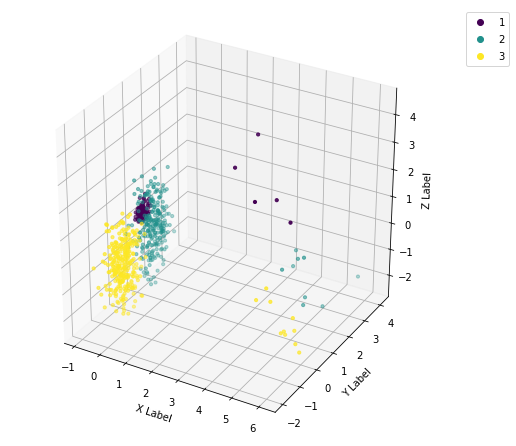

In [10]:
import re, seaborn as sns
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

pca = PCA(n_components=15,whiten=True)
pca.fit(ms_features)
ms_features_new = pca.transform(ms_features)

# generate data
n = 200
x = ms_features_new[:, 0]
y = ms_features_new[:, 1]
z = ms_features_new[:, 2]

# axes instance
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)

# get colormap from seaborn
# cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
cmap = ms_real['class']

# plot
sc = ax.scatter(x, y, z, s=10, c=cmap, marker='o')#, cmap=cmap, alpha=1)
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

# save
# plt.savefig("scatter_hue", bbox_inches='tight')

# MS with t-SNE

Trying t-SNE on ms dataset, the data turns out not a spiral shaped and classes are not separated. 

In [11]:
# t-SNE
m = TSNE(learning_rate = 50)
tsne_features = m.fit_transform(ms_features)

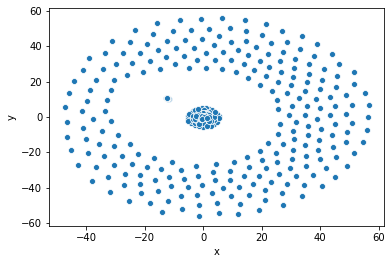

In [12]:
df = pd.DataFrame()
df["x"] = tsne_features[:,0]
df["y"] = tsne_features[:,1]

sns.scatterplot(x="x",y="y",data=df)
plt.show()

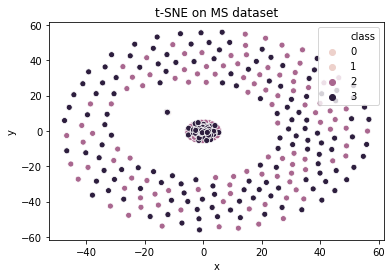

In [13]:
sns.scatterplot(x="x",y="y",data=df, hue = ms_real["class"]).set_title("t-SNE on MS dataset")
plt.show()

### Testing different parameters and record the best result with MS UMAP SpectralClustering

In [14]:
import warnings
warnings.filterwarnings('ignore')

# loop_result = False

# save best record
if "ms_best_result_dict.save" in os.listdir():
    ms_best_result_dict = pickle.load(open("ms_best_result_dict.save", "rb"))
    print("load ms best successfully",ms_best_result_dict)
else:
    ms_best_result_dict = {"canberra":0, "braycurtis":0}
    pickle.dump(ms_best_result_dict, open("ms_best_result_dict.save", "wb"))

if loop_result == True:
    counter = 0
    while counter <= 10:
        for metric in ["canberra","braycurtis"]:
            embedding = umap.UMAP(n_neighbors=7,
                                  min_dist=0.1,
                                  metric=metric).fit_transform(ms_features_log_minmax)
            clustering = SpectralClustering(n_clusters=3,random_state=0,affinity="rbf")
            label = clustering.fit_predict(embedding)
            NMI = normalized_mutual_info_score(label, ms_real["class"],average_method="geometric")
            
            # load best result
            ms_best_result_dict = pickle.load(open( "ms_best_result_dict.save", "rb"))
            best_ms = ms_best_result_dict[max(ms_best_result_dict, key=ms_best_result_dict.get)]
            
            if NMI > best_ms:
                print(metric, NMI)
                
                # save solution label
                filename = "solution2_ms_" + str(np.round(NMI,4)) + ".txt"
                np.savetxt(filename,label,fmt= "%d")
                
                # save best result
                pickle.dump(ms_best_result_dict, open("ms_best_result_dict.save", "wb"))
        print(counter)
        counter += 1
print(ms_best_result_dict)

load ms best successfully {'canberra': 0.9377, 'braycurtis': 0.9432117452943786}
{'canberra': 0.9377, 'braycurtis': 0.9432117452943786}


In [15]:
if loop_result == True:
    metrics = ["euclidean", "manhattan", "chebyshev", "minkowski", "canberra", "braycurtis", "wminkowski", "cosine", "correlation", "hamming", 
               "jaccard", "dice", "russelrao", "kulsinski", "ll_dirichlet", "hellinger", "rogerstanimoto", "sokalmichener", "sokalsneath", "yule"]
    for metric in metrics:
        try:
            embedding = umap.UMAP(n_neighbors=3,
                                  min_dist=0.1,
                                  metric=metric).fit_transform(ms_features_scaled)
            clustering = SpectralClustering(n_clusters=3,random_state=0,affinity="rbf")
            label = clustering.fit_predict(embedding)
            print(metric, normalized_mutual_info_score(label, ms_real["class"],average_method="geometric"))
        except:
            print(metric, "error")

In [16]:
if loop_result == True:
    best = 0.9
    counter = 0
    for state in range(100,1000):
        embedding = umap.UMAP(n_neighbors=7,
                              min_dist=0.1,
                              metric="braycurtis",random_state=state).fit_transform(ms_features_log_minmax)
        clustering = AgglomerativeClustering(n_clusters=3)
        label = clustering.fit_predict(embedding)
        NMI = normalized_mutual_info_score(label, ms_real["class"],average_method="geometric")
        if NMI > best:
            print(state, NMI)
            best = NMI
        counter += 1
        if counter % 10 == 0:
            print(int(counter/1000*100),"%")

### testing different parameteres on ms umap Agglomerative Clustering

In [17]:
import warnings
warnings.filterwarnings('ignore')

# loop_result = False

# save best record
if "ms_best_result_dict.save" in os.listdir():
    ms_best_result_dict = pickle.load(open("ms_best_result_dict.save", "rb"))
    print("load ms best successfully",ms_best_result_dict)
else:
    ms_best_result_dict = {"canberra":0, "braycurtis":0}
    pickle.dump(ms_best_result_dict, open("ms_best_result_dict.save", "wb"))

if loop_result == True:
    counter = 0
    while counter <= 100:
        for metric in ["canberra","braycurtis"]:
            embedding = umap.UMAP(n_neighbors=7,
                                  min_dist=0.1,
                                  metric=metric).fit_transform(ms_features_log_minmax)
            clustering = AgglomerativeClustering(n_clusters=3)
            label = clustering.fit_predict(embedding)
            NMI = normalized_mutual_info_score(label, ms_real["class"],average_method="geometric")
            
            # load best result
            ms_best_result_dict = pickle.load(open( "ms_best_result_dict.save", "rb"))
            best_ms = ms_best_result_dict[max(ms_best_result_dict, key=ms_best_result_dict.get)]
            
            if NMI > best_ms:
                print(metric, NMI)
                
                # save solution label
                filename = "solution2_ms_" + str(np.round(NMI,4)) + ".txt"
                np.savetxt(filename,label,fmt= "%d")
                
                # save best result
                ms_best_result_dict[metric] = NMI
                pickle.dump(ms_best_result_dict, open("ms_best_result_dict.save", "wb+"))
        print(counter)
        counter += 1
print(ms_best_result_dict)

load ms best successfully {'canberra': 0.9377, 'braycurtis': 0.9432117452943786}
{'canberra': 0.9377, 'braycurtis': 0.9432117452943786}


### Gene with different parameters Kmeans umap and plot the best result

In [18]:
# loop_result = True

if loop_result == True:
    NMI_umap_gene = 0
    i = 0
    while NMI_umap_gene <=0.95:
        i += 1
        embedding = umap.UMAP(n_neighbors=5,
                              min_dist=0.3,
                              metric='correlation').fit_transform(gene_features)

        kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=3000, n_init=20, random_state=0)
        pred_y = kmeans.fit_predict(embedding)
        NMI_umap_gene = normalized_mutual_info_score(pred_y, gene_real["class"],average_method="geometric")
        print(NMI_umap_gene)
        print(i, "\n ---------- \n")

    # only print out comparison if the result is good enough e.g. > 0.95
    fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

    ax1.scatter(embedding[:,0], embedding[:,1], 
                c=gene_real["class"], 
                edgecolor='none', 
                alpha=0.8, 
                s=7)
    ax1.set_title('Actual Classes');

    ax2.scatter(embedding[:,0], embedding[:,1], 
                c=pred_y, 
                edgecolor='none', 
                alpha=0.8, 
                s=7)
    ax2.set_title('Predict Classes')
    normalized_mutual_info_score(pred_y, gene_real["class"],average_method="geometric")

In [19]:
# loop_result = False
if loop_result == True:
    best = 0.9
    counter = 0
    for state in range(1000,2000):
        embedding = umap.UMAP(n_neighbors=5,
                              min_dist=0.3,
                              metric="correlation",random_state=state).fit_transform(gene_features)
        kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=3000, n_init=20, random_state=0)
        pred_y = kmeans.fit_predict(embedding)
        NMI = normalized_mutual_info_score(pred_y, gene_real["class"],average_method="geometric")
        if NMI > best:
            print(state, NMI)
            best = NMI
        counter += 1
        if counter % 10 == 0:
            print(int(counter/1000*100),"%")

## test gene parameteres with kmeans

In [20]:
if loop_result == True:
    metrics = ["euclidean", "manhattan", "chebyshev", "minkowski", "canberra", "braycurtis", "wminkowski", "cosine", "correlation", "hamming", 
               "jaccard", "dice", "russelrao", "kulsinski", "ll_dirichlet", "hellinger", "rogerstanimoto", "sokalmichener", "sokalsneath", "yule"]
    for metric in metrics:
        try:
            embedding = umap.UMAP(n_neighbors=5,
                                  min_dist=0.3,
                                  metric=metric).fit_transform(gene_features)
            kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=3000, n_init=20, random_state=0)
            pred_y = kmeans.fit_predict(embedding)
            NMI_umap_gene = normalized_mutual_info_score(pred_y, gene_real["class"],average_method="geometric")
            print(metric, NMI_umap_gene)
        except KeyboardInterrupt:
            break
        except:
            print(metric, "error")

In [21]:
import warnings
warnings.filterwarnings('ignore')

# loop_result = True


# save best record
if "gene_best_result_float.save" in os.listdir():
    gene_best_result_float = pickle.load(open("gene_best_result_float.save", "rb"))
    print("load gene best successfully",gene_best_result_float)
else:
    gene_best_result_float = 0.0
    pickle.dump(gene_best_result_float, open("gene_best_result_float.save", "wb"))

if loop_result == True:
    counter = 0
    while counter <= 1:
        embedding = umap.UMAP(n_neighbors=5,
                              min_dist=0.3,
                              metric='correlation').fit_transform(gene_features)
        kmeans = KMeans(n_clusters=5, init='k-means++', max_iter=3000, n_init=20, random_state=0)
        pred_y = kmeans.fit_predict(embedding)
        NMI_umap_gene = normalized_mutual_info_score(pred_y, gene_real["class"],average_method="geometric")
            
        # load best result
        gene_best_result_float = pickle.load(open( "gene_best_result_float.save", "rb"))
        best_gene = gene_best_result_float

        if NMI_umap_gene > best_gene:
            print(metric, NMI_umap_gene)

            # save solution label
            filename = "solution1_gene_" + str(np.round(NMI_umap_gene,4)) + ".txt"
            np.savetxt(filename,pred_y,fmt= "%d")

            # save best result
            gene_best_result_float = NMI_umap_gene
            pickle.dump(gene_best_result_float, open("gene_best_result_float.save", "wb+"))
        print(counter)
        counter += 1
print(gene_best_result_float)

if output_text == True:
    np.savetxt('solution1_gene.txt',pred_y,fmt= "%d")

load gene best successfully 0.9193956350519724
0.9193956350519724


### test ms with parameters kmeans

In [22]:
if loop_result == True:
    for i in range(2,20):
        embedding = umap.UMAP(n_neighbors=i,
                              min_dist=0.1,
                              metric='correlation').fit_transform(ms_features)

        sns.scatterplot(x= embedding[:,0],y = embedding[:,1],hue = np.array(ms_real["class"]),palette=color_dict)
        print(i)
        kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
        pred_y = kmeans.fit_predict(embedding)
        # pred_y
        print(normalized_mutual_info_score(pred_y, ms_real["class"],average_method="geometric"))
        plt.show()

In [23]:
if loop_result == True:
    result = {}
    for i in range(1,100):
        i = i/100
        embedding = umap.UMAP(n_neighbors=19,
                              min_dist=i,
                              metric='correlation').fit_transform(ms_features)

    #     sns.scatterplot(x= embedding[:,0],y = embedding[:,1],hue = np.array(ms_real["class"]),palette=color_dict)
        kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
        pred_y = kmeans.fit_predict(embedding)
        nmi_ms_umap = normalized_mutual_info_score(pred_y, ms_real["class"],average_method="geometric")
        result[i] = nmi_ms_umap
        if (i*100) %10 ==0:
            print(i)
    maximum  = max(result, key=result.get)
    print(maximum, result[maximum])

In [24]:
if loop_result == True:
    nmi_ms_umap = 0
    while nmi_ms_umap<= 0.61:
        embedding = umap.UMAP(n_neighbors=19,
                              min_dist=0.98,
                              metric='correlation').fit_transform(ms_features)

        # sns.scatterplot(x= embedding[:,0],y = embedding[:,1],hue = np.array(ms_real["class"]),palette=color_dict)
        kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
        pred_y = kmeans.fit_predict(embedding)
        nmi_ms_umap = normalized_mutual_info_score(pred_y, ms_real["class"],average_method="geometric")
        print(nmi_ms_umap)
        normalized_mutual_info_score(pred_y, ms_real["class"],average_method="geometric")

In [25]:
if output_text == True:
    np.savetxt('solution2_ms.txt',pred_y,fmt= "%d")